In [2]:
%%capture
! pip install arviz==0.11.00
! pip install pymc3==3.10.0

# Mixture models

In [32]:
import os
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
import seaborn as sns
from scipy import stats
import theano.tensor as tt

sns.set_context('talk')

## Data

In [22]:
x = np.concatenate([np.random.normal(100, 15, 100), np.random.normal(50, 10, 20)])

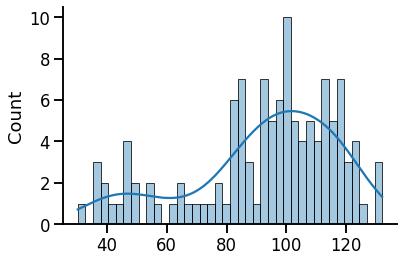

In [23]:
sns.histplot(x, bins=40, alpha=0.4, kde=True)
sns.despine()

In [24]:
clusters = 2

## A simple mixture model

In [26]:
with pm.Model() as model_kg:
  p = pm.Dirichlet('p', a=np.ones(clusters))
  z = pm.Categorical('z', p=p, shape=len(x))
  means = pm.Normal('means', mu=x.mean(), sd=10, shape=clusters)
  sd = pm.HalfNormal('sd', sd=10)
  y = pm.Normal('y', mu=means[z], sd=sd, observed=x)
  trace_kg = pm.sample()

/usr/local/lib/python3.7/dist-packages/pymc3/sampling.py:468: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Sequential sampling (2 chains in 1 job)
CompoundStep
>NUTS: [sd, means, p]
>BinaryGibbsMetropolis: [z]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 42 seconds.


## Reparametrizing

In [27]:
with pm.Model() as model_mg:
  p = pm.Dirichlet('p', a=np.ones(clusters))
  means = pm.Normal('means', mu=x.mean(), sd=10, shape=clusters)
  sd = pm.HalfNormal('sd', sd=10)
  y = pm.NormalMixture('y', w=p, mu=means, sd=sd, observed=x)
  trace_mg = pm.sample(random_seed=123)

/usr/local/lib/python3.7/dist-packages/pymc3/sampling.py:468: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sd, means, p]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 7 seconds.
The acceptance probability does not match the target. It is 0.9720374624994922, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


/usr/local/lib/python3.7/dist-packages/arviz/data/io_pymc3.py:92: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f027dc774d0>,
      dtype=object)

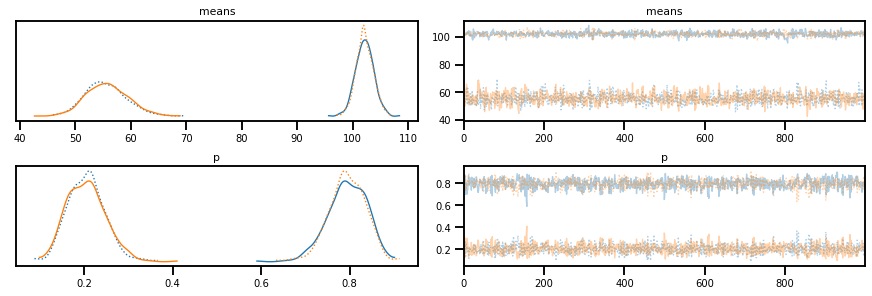

In [29]:
az.plot_trace(trace_mg, var_names = ['means', 'p'])

In [30]:
az.summary(trace_mg, var_names = ['means', 'p'])

/usr/local/lib/python3.7/dist-packages/arviz/data/io_pymc3.py:92: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
means[0],78.829,23.526,51.010,105.526,16.473,13.934,2.0,2.0,3.0,56.0,1.83
means[1],78.967,23.415,50.865,105.041,16.390,13.868,2.0,2.0,3.0,78.0,1.83
p[0],0.500,0.298,0.145,0.857,0.208,0.175,2.0,2.0,3.0,58.0,1.83
p[1],0.500,0.298,0.143,0.855,0.208,0.175,2.0,2.0,3.0,58.0,1.83


## Non-identifibility of mixture models

In [34]:
with pm.Model() as model_mgp:
  p = pm.Dirichlet('p', a=np.ones(clusters))
  means = pm.Normal('means', mu=np.array([.9, 1]) * x.mean(),
  sd=10, shape=clusters)
  sd = pm.HalfNormal('sd', sd=10)
  order_means = pm.Potential('order_means', 
                             tt.switch(means[1]-means[0] < 0, -np.inf, 0))
  y = pm.NormalMixture('y', w=p, mu=means, sd=sd, observed=x)
  trace_mgp = pm.sample(1000, random_seed=123)

/usr/local/lib/python3.7/dist-packages/pymc3/sampling.py:468: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sd, means, p]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 6 seconds.


/usr/local/lib/python3.7/dist-packages/arviz/data/io_pymc3.py:92: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f027bcd6f10>,
      dtype=object)

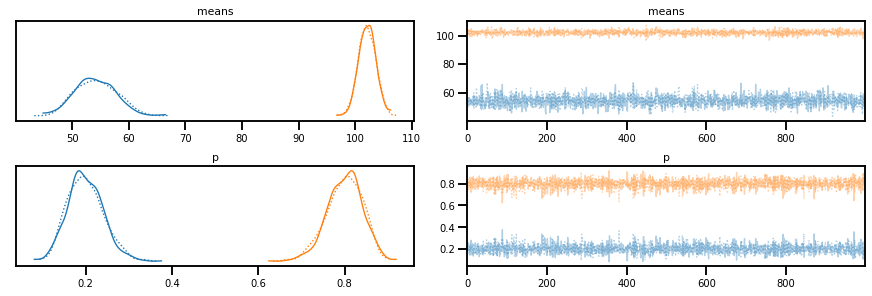

In [35]:
az.plot_trace(trace_mgp, var_names = ['means', 'p'])

In [36]:
az.summary(trace_mgp, var_names = ['means', 'p'])

/usr/local/lib/python3.7/dist-packages/arviz/data/io_pymc3.py:92: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
means[0],54.185,3.665,47.669,60.927,0.084,0.060,1912.0,1884.0,1909.0,1406.0,1.0
means[1],102.117,1.523,99.395,105.091,0.033,0.023,2149.0,2149.0,2152.0,1529.0,1.0
p[0],0.200,0.042,0.128,0.282,0.001,0.001,2633.0,2537.0,2633.0,1532.0,1.0
p[1],0.800,0.042,0.718,0.872,0.001,0.001,2633.0,2633.0,2633.0,1532.0,1.0


# Exercises

1. Generate synthetic from a mixture of three Gaussians. Check [the accompanying Jupyter Notebook](https://github.com/aloctavodia/BAP/blob/master/first_edition/code/Chp7/07_Mixture_Models.ipynb) for this chapter for an example on how to do this. Fit a finite
Gaussian mixture model with 2, 3, or 4 components.
2. Use WAIC and LOO to compare the results from exercise 1.